In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive',force_remount = False)

In [ ]:
!pip install miscnn
!pip install matplotlib==3.3.1

**Training code**

In [ ]:
# Standard libraries
import tensorflow as tf
import os
import random
import numpy as np
import argparse
import math

# MIScnn
from miscnn.neural_network.metrics import identify_axis
from miscnn.processing.data_augmentation import Data_Augmentation
from miscnn.processing.subfunctions.normalization import Normalization
from miscnn.processing.subfunctions.resize import Resize
from miscnn.processing.subfunctions.clipping import Clipping
from miscnn.processing.subfunctions.resampling import Resampling
from miscnn.processing.preprocessor import Preprocessor
from miscnn.neural_network.model import Neural_Network
from miscnn.neural_network.metrics import dice_soft, dice_soft_loss

from miscnn.neural_network.architecture.unet.standard import Architecture 

from miscnn.evaluation.cross_validation import run_fold, load_disk2fold
from miscnn.data_loading.interfaces.image_io import Image_interface
from miscnn.data_loading.data_io import Data_IO

# Tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#Generating interface: single channel with 2 classes (background and enhancing tumour)
interface = Image_interface(pattern = "case_[0-9]*" # Pattern may differ depending on folder structure
                                 , img_type = 'rgb'
                                 , img_format = 'tif'
                                 , classes = 2)

# path to data folder
data_path ="/content/drive/My Drive/CVC/data"

# Generating dataloader
data_io = Data_IO(interface, data_path, delete_batchDir=False)

# Sample list
sample_list = data_io.get_indiceslist()
sample_list.sort()

# Basic checks
print("All samples: " + str(len(sample_list)))
sample = data_io.sample_loader(sample_list[0], load_seg=True)  
print("Image dimension check:",sample.img_data.shape, sample.seg_data.max())

All samples: 612
Image dimension check: (288, 384, 3) 1


In [ ]:
# Data augmentation
data_aug = Data_Augmentation(cycles=1, scaling=True, rotations=True, elastic_deform=True, mirror=True,
                             brightness=True, contrast=False, gamma=False, gaussian_noise=False)


# Data preprocessing parameters
sf_normalize = Normalization(mode='z-score')
sf_resize = Resize((288,384))
subfunctions = [sf_resize, sf_normalize]


# Create preprocessing class
pp = Preprocessor(data_io
                  , data_aug=data_aug
                  , batch_size=1
                  , prepare_subfunctions=True
                  , subfunctions=subfunctions
                  , prepare_batches=False
                  , analysis="fullimage"
                  , use_multiprocessing=False)

In [ ]:
# Loss functions

# Dice++ loss
def dice_plus_loss(gamma=2):

    def loss_function(y_true, y_pred):
        axis=identify_axis(y_true.get_shape())
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred,epsilon,1-epsilon)
        y_true = K.clip(y_true,epsilon,1-epsilon)
        delta = 0.5
        tp = K.sum(y_true * y_pred, axis=axis)
        fn = K.sum((y_true * (1-y_pred))**gamma, axis=axis)
        fp = K.sum(((1-y_true) * y_pred)**gamma, axis=axis)
        dice_class = (tp + epsilon)/(tp + delta*fn + (1-delta)*fp + epsilon)
        loss = K.mean(1-dice_class)

        return loss

    return loss_function

# Cross entropy loss
def cross_entropy(y_true, y_pred):

        axis = identify_axis(y_true.get_shape())
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        cross_entropy = K.mean(K.sum(cross_entropy, axis=[-1]))

        return cross_entropy

# Focal loss
def focal_loss(alpha=0.5, gamma=2.):
    def loss_function(y_true, y_pred):
        axis = identify_axis(y_true.get_shape())
        # Clip values to prevent division by zero error
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)

        if alpha is not None:
            alpha_weight = np.array(alpha, dtype=np.float32)
            focal_loss = alpha_weight * K.pow(1 - y_pred, gamma) * cross_entropy
        else:
            focal_loss = K.pow(1 - y_pred, gamma) * cross_entropy

        focal_loss = K.mean(K.sum(focal_loss, axis=[-1]))
        return focal_loss
        
    return loss_function

In [ ]:
# U-Net
architecture = Architecture()

# Here the loss function is chosen:
# Either cross_entropy, dice_soft_loss, focal_loss() or dice_plus_loss()
loss = dice_plus_loss()

# Create the Neural Network model
model = Neural_Network(architecture=architecture
                      , preprocessor=pp
                      , loss=loss
                      , metrics=[dice_soft]
                      , batch_queue_size=3
                      , workers=1
                      , learning_rate=0.1)


In [ ]:
# Learning rate schedule
cb_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25, verbose=1, mode='min', min_delta=1e-7, cooldown=1,    
                          min_lr=1e-4)

cb_es = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=50, verbose=1, mode='min')

In [ ]:
# Run pipeline for cross-validation fold
run_fold(fold=0
         , model=model
         , epochs=1000
         , evaluation_path='/content/drive/My Drive/CVC/output'
         , draw_figures=True
         , callbacks=[cb_lr,cb_es]
         , save_models=True
        )

**Evaluation code**

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


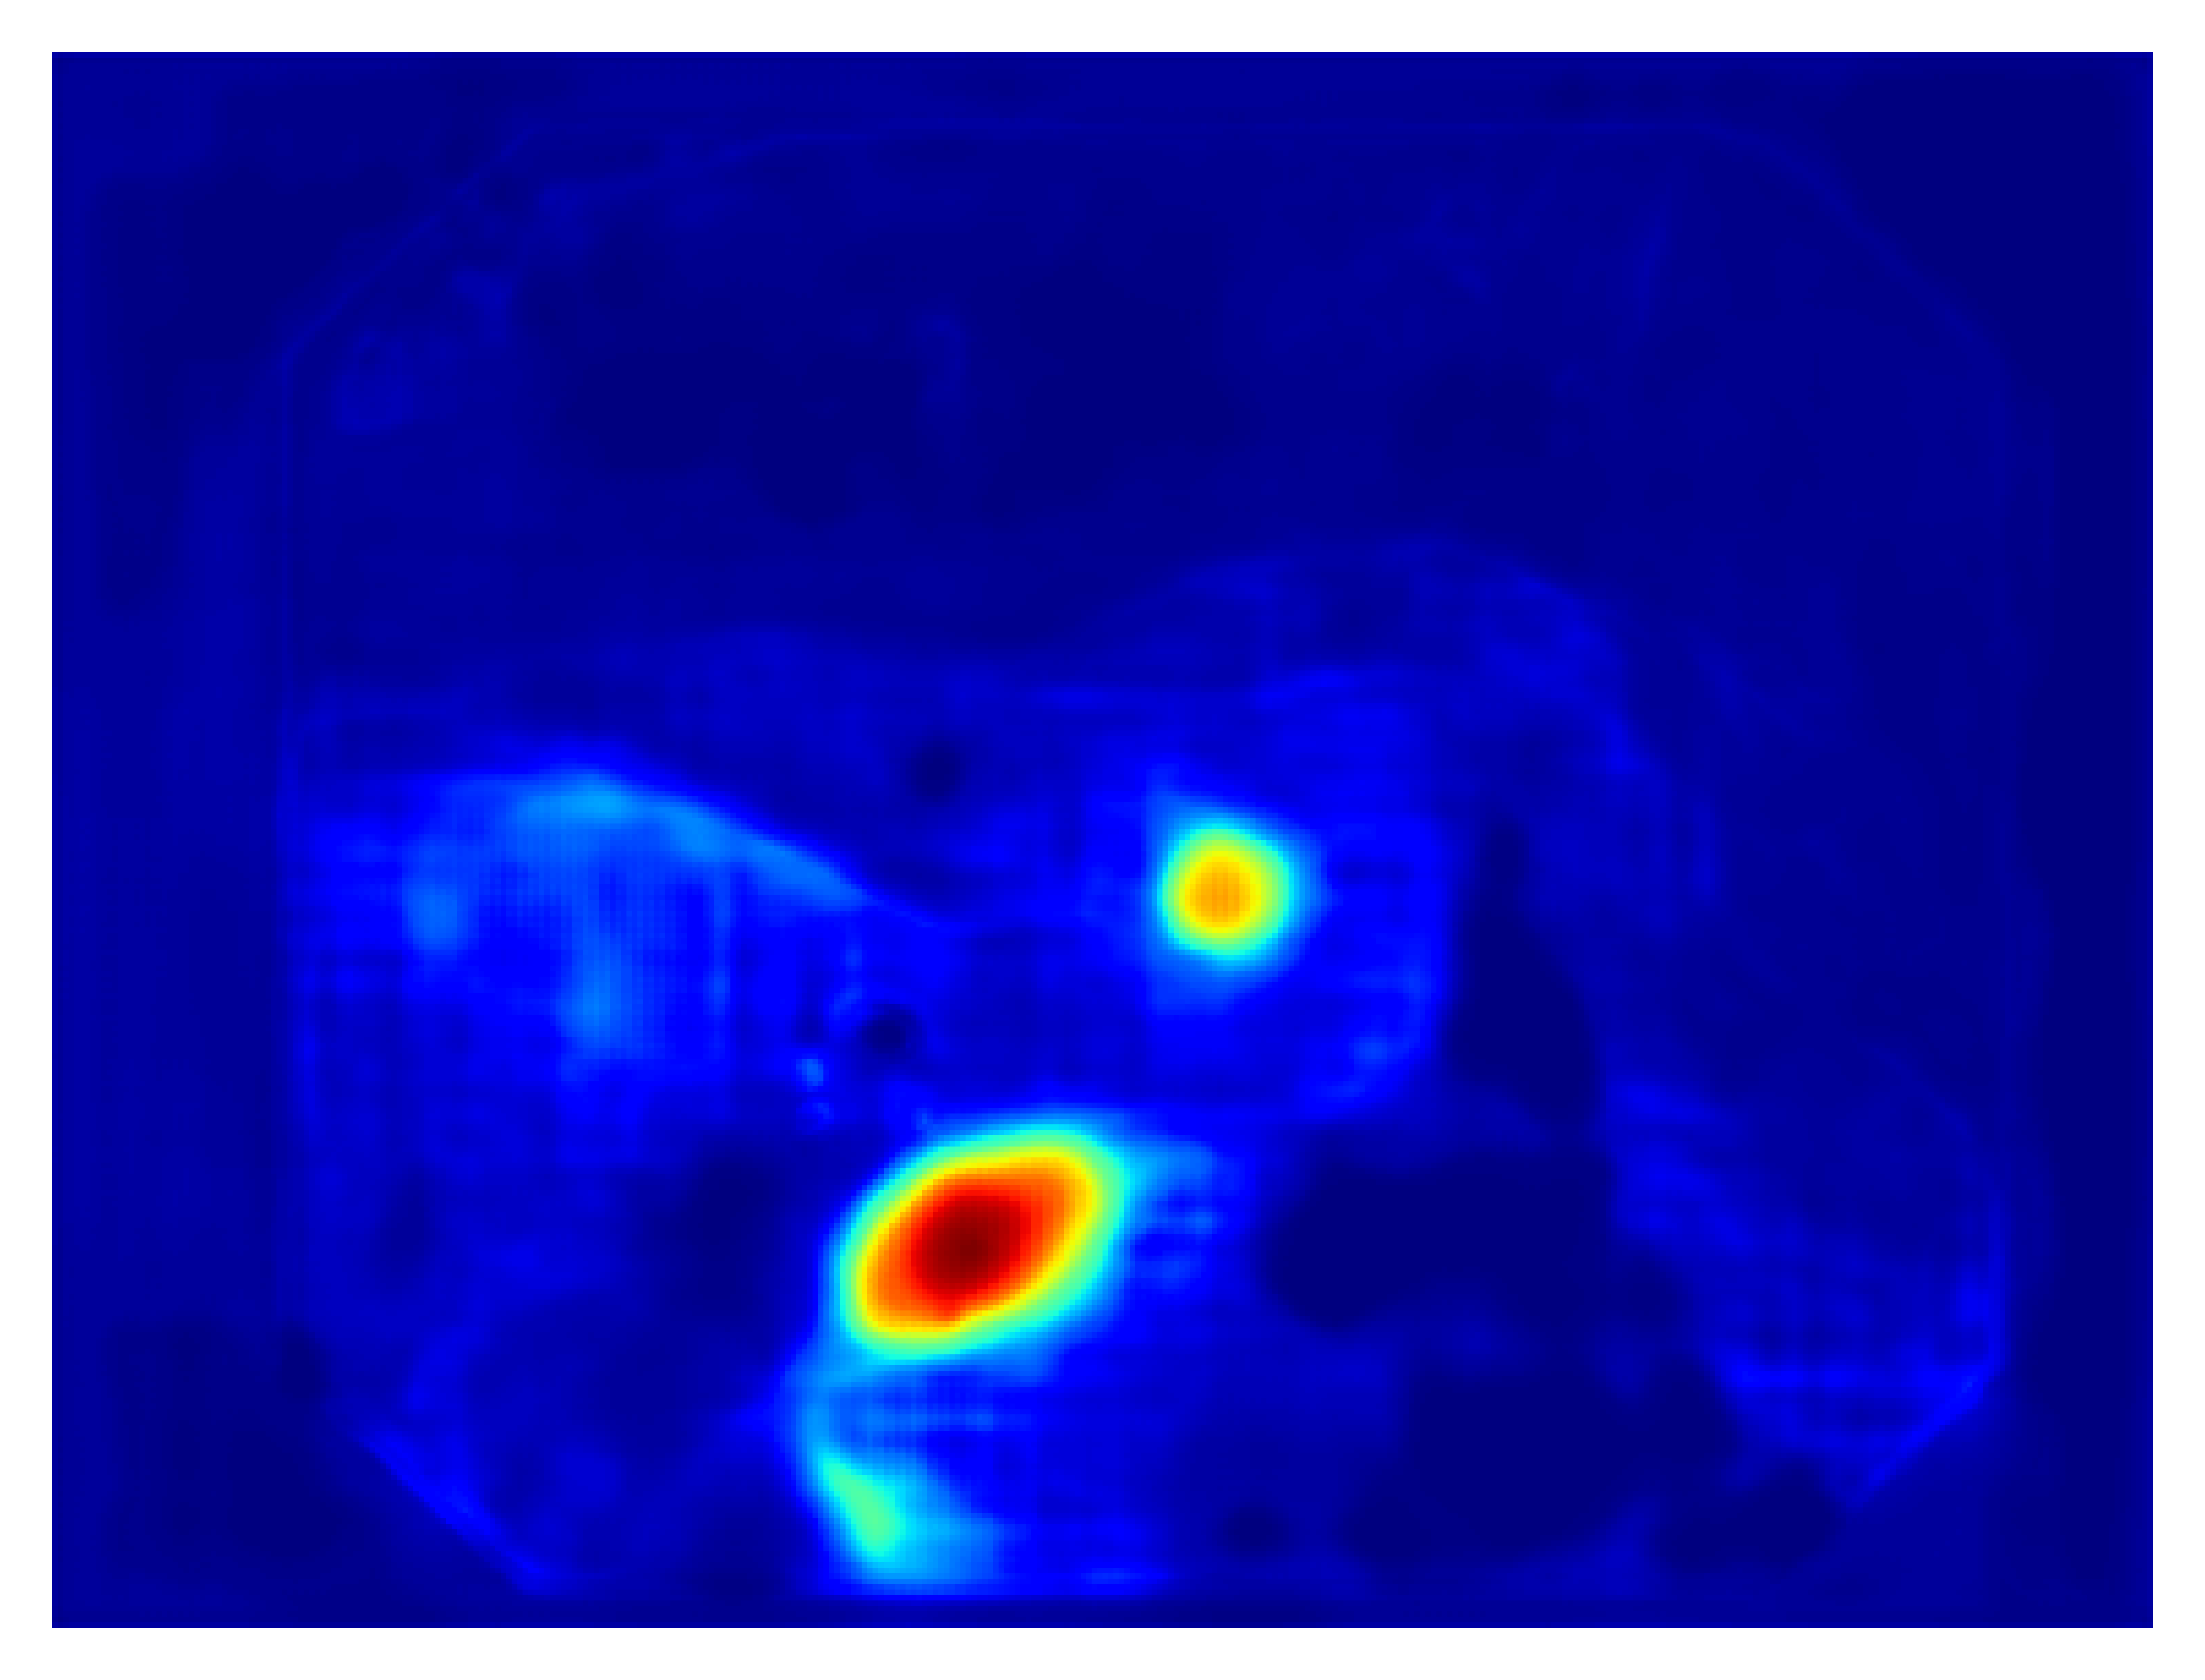

In [ ]:
from miscnn.data_loading.data_io import backup_evaluation
import json
import skimage
from skimage.transform import resize
import matplotlib.pyplot as plt

# Change paths as necessary
path = os.path.join('/content/drive/My Drive/CVC/output','fold_0','model.hdf5')
training,validation = load_disk2fold(os.path.join('/content/drive/My Drive/CVC/output','fold_0','testing.json'))
evaluation_path = os.path.join('/content/drive/My Drive/CVC/output/fold_0')

# load model
model.load(path)


def load_disk2fold(file_path):
    with open(file_path, "r") as jsonfile:
        sampling = json.load(jsonfile)
        if "TRAINING" in sampling : training = sampling["TRAINING"]
        else : training = None
        if "VALIDATION" in sampling : validation = sampling["VALIDATION"]
        else : validation = None
    return training, validation


def compute_brier(truth, pred, classes):
    brier_scores = []
    # Compute Dice for each class
    i = 1
    try:
        brier = np.mean(((truth[:,:,0] - pred[:,:,classes])**2))
        brier_scores.append(brier)
    except ZeroDivisionError:
        brier_scores.append(0.0)
    # Return computed Dice scores
    return brier_scores

def compute_nll(truth, pred, classes):
    nll_scores = []
    # Compute Dice for each class
    i = 1
    try:
        epsilon = K.epsilon()   
        pred = np.clip(pred, epsilon, 1. - epsilon)
        cross_entropy = -(truth[:,:,0] * np.log(pred[:,:,classes]))

        cross_entropy = np.mean(cross_entropy)
        nll_scores.append(cross_entropy)

    except ZeroDivisionError:
        nll_scores.append(0.0)
    # Return computed Dice scores
    return nll_scores

# Calculate class-wise dice similarity coefficient
def compute_dice(truth, pred, classes):
    dice_scores = []
    # Compute Dice for each class
    i = 1
    try:
        pd = np.equal(pred, i)
        gt = np.equal(truth[:,:,0], i)
        dice = 2*np.logical_and(pd, gt).sum()/(pd.sum() + gt.sum())
        dice_scores.append(dice)
    except ZeroDivisionError:
        dice_scores.append(0.0)
    # Return computed Dice scores
    return dice_scores

def compute_iou(truth, pred, classes):
    iou_scores = []
    # Compute Dice for each class
    i = 1
    try:
        pd = np.equal(pred, i)
        gt = np.equal(truth[:,:,0], i)
        tp = np.logical_and(pd,gt).sum()
        fp = np.logical_and(pd,np.logical_not(gt)).sum()
        fn = np.logical_and(gt,np.logical_not(pd)).sum()
        iou = tp / (tp + fp + fn)
        iou_scores.append(iou)
    except ZeroDivisionError:
        iou_scores.append(0.0)
    return iou_scores

def compute_rest(truth, pred, classes):
    precision_scores = []
    recall_scores = []
    # Compute precision, recall scores for each class
    i = 1
    try:
        pd = np.equal(pred, i)
        gt = np.equal(truth[:,:,0], i)
        tp = np.logical_and(pd,gt).sum()
        fp = np.logical_and(pd,np.logical_not(gt)).sum()
        fn = np.logical_and(gt,np.logical_not(pd)).sum()
        precision = tp/(tp+fp)
        precision_scores.append(precision)
    except ZeroDivisionError:
        precision_scores.append(0.0) 

    try:
        recall = tp/(tp+fn)
        recall_scores.append(recall)
    except ZeroDivisionError:
        recall_scores.append(0.0)
            
    # Return computed precision, recall scores 
    return precision_scores, recall_scores

# Initialize detailed validation scoring file
classes = ["nll_score"]
classes_1 = ["brier_score"]
classes_2 = ["dice_score"]
classes_3 = ["iou_score"]  
classes_4 = ["precision_score"]  
classes_5 = ["recall_score"]          
header = ["sample_id"]
header.extend(classes)
header.extend(classes_1)
header.extend(classes_2)
header.extend(classes_3)
header.extend(classes_4)
header.extend(classes_5)
backup_evaluation(header, evaluation_path, start=True)

for sample_index in validation:
        pred = model.predict([sample_index],return_output=True,activation_output=True)

        # get prediction from list of predictions
        pred = pred[0]

        # Load the sample
        sample = model.preprocessor.data_io.sample_loader(sample_index,
                                                          load_seg=True,
                                                          load_pred=False)
        # Access image and ground truth segmentation data
        img, seg = sample.img_data, sample.seg_data

        # resize segmentation to size of prediction activations
        seg_act = resize(seg,(pred.shape[0], pred.shape[1]),order=0, preserve_range=True,anti_aliasing=False)

        # Compute calibration metrics
        nll_scores = compute_nll(seg_act, pred, 1)
        brier_scores = compute_brier(seg_act, pred, 1)

        # convert softmax predictions to classes
        pred = np.argmax(pred,axis=-1)
        
        # resize final prediction to original image shape
        pred = resize(pred,(seg.shape[0], seg.shape[1]),order=0, preserve_range=True,anti_aliasing=False)

        # Compute segmentation metrics
        dice_scores = compute_dice(seg, pred, 1)
        iou_scores = compute_iou(seg, pred, 1)
        precision_scores, recall_scores = compute_rest(seg, pred, 1)
        
        # Save detailed validation scores to file
        scores = [sample_index]
        scores.extend(nll_scores)
        scores.extend(brier_scores)
        scores.extend(dice_scores)
        scores.extend(iou_scores)
        scores.extend(precision_scores)
        scores.extend(recall_scores)
        backup_evaluation(scores, evaluation_path, start=False)   

In [ ]:
from miscnn.data_loading.data_io import backup_evaluation
import json
import skimage
from skimage.transform import resize

def load_disk2fold(file_path):
    with open(file_path, "r") as jsonfile:
        sampling = json.load(jsonfile)
        if "TRAINING" in sampling : training = sampling["TRAINING"]
        else : training = None
        if "VALIDATION" in sampling : validation = sampling["VALIDATION"]
        else : validation = None
    return training, validation


def compute_brier(truth, pred, classes):
    brier_scores = []
    # Compute Dice for each class
    i = 1
    try:
        brier = np.mean(((truth[:,:,0] - pred[:,:,classes])**2))
        brier_scores.append(brier)
    except ZeroDivisionError:
        brier_scores.append(0.0)
    # Return computed Dice scores
    return brier_scores

def compute_nll(truth, pred, classes):
    nll_scores = []
    # Compute Dice for each class
    i = 1
    try:
        epsilon = K.epsilon()   
        pred = np.clip(pred, epsilon, 1. - epsilon)
        cross_entropy = -(truth[:,:,0] * np.log(pred[:,:,classes]))

        cross_entropy = np.mean(cross_entropy)
        nll_scores.append(cross_entropy)

    except ZeroDivisionError:
        nll_scores.append(0.0)
    # Return computed Dice scores
    return nll_scores

# Calculate class-wise dice similarity coefficient
def compute_dice(truth, pred, classes):
    dice_scores = []
    # Compute Dice for each class
    i = 1
    try:
        pd = np.equal(pred, i)
        gt = np.equal(truth[:,:,0], i)
        dice = 2*np.logical_and(pd, gt).sum()/(pd.sum() + gt.sum())
        dice_scores.append(dice)
    except ZeroDivisionError:
        dice_scores.append(0.0)
    # Return computed Dice scores
    return dice_scores

def compute_iou(truth, pred, classes):
    iou_scores = []
    # Compute Dice for each class
    i = 1
    try:
        pd = np.equal(pred, i)
        gt = np.equal(truth[:,:,0], i)
        tp = np.logical_and(pd,gt).sum()
        fp = np.logical_and(pd,np.logical_not(gt)).sum()
        fn = np.logical_and(gt,np.logical_not(pd)).sum()
        iou = tp / (tp + fp + fn)
        iou_scores.append(iou)
    except ZeroDivisionError:
        iou_scores.append(0.0)
    return iou_scores

def compute_rest(truth, pred, classes):
    precision_scores = []
    recall_scores = []
    # Compute precision, recall scores for each class
    i = 1
    try:
        pd = np.equal(pred, i)
        gt = np.equal(truth[:,:,0], i)
        tp = np.logical_and(pd,gt).sum()
        fp = np.logical_and(pd,np.logical_not(gt)).sum()
        fn = np.logical_and(gt,np.logical_not(pd)).sum()
        precision = tp/(tp+fp)
        precision_scores.append(precision)
    except ZeroDivisionError:
        precision_scores.append(0.0) 

    try:
        recall = tp/(tp+fn)
        recall_scores.append(recall)
    except ZeroDivisionError:
        recall_scores.append(0.0)
            
    # Return computed precision, recall scores 
    return precision_scores, recall_scores

path = os.path.join('/content/drive/My Drive/CVC/output','fold_0','model.hdf5')

training,validation = load_disk2fold(os.path.join('/content/drive/My Drive/CVC/output','fold_0','testing.json'))

model.load(path)

evaluation_path = os.path.join('/content/drive/My Drive/CVC/output/fold_0')

# Initialize detailed validation scoring file
classes = ["nll_score"]
classes_1 = ["brier_score"]
classes_2 = ["dice_score"]
classes_3 = ["iou_score"]  
classes_4 = ["precision_score"]  
classes_5 = ["recall_score"]          
header = ["sample_id"]
header.extend(classes)
header.extend(classes_1)
header.extend(classes_2)
header.extend(classes_3)
header.extend(classes_4)
header.extend(classes_5)
backup_evaluation(header, evaluation_path, start=True)

for sample_index in validation:
        pred = model.predict([sample_index],return_output=True,activation_output=True)
        pred = pred[0]

        # Load the sample
        sample = model.preprocessor.data_io.sample_loader(sample_index,
                                                          load_seg=True,
                                                          load_pred=False)
        # Access image, truth and predicted segmentation data
        img, seg = sample.img_data, sample.seg_data
        # Calculate classwise dice score
        seg1 = resize(seg,(pred.shape[0], pred.shape[1]),order=0, preserve_range=True,anti_aliasing=False)

        nll_scores = compute_nll(seg1, pred, 1)
        brier_scores = compute_brier(seg1, pred, 1)

        pred = np.argmax(pred,axis=-1)
        pred = resize(pred,(seg.shape[0], seg.shape[1]),order=0, preserve_range=True,anti_aliasing=False)


        dice_scores = compute_dice(seg, pred, 1)
        iou_scores = compute_iou(seg, pred, 1)
        precision_scores, recall_scores = compute_rest(seg, pred, 1)
        # Save detailed validation scores to file
        scores = [sample_index]
        scores.extend(nll_scores)
        scores.extend(brier_scores)
        scores.extend(dice_scores)
        scores.extend(iou_scores)
        scores.extend(precision_scores)
        scores.extend(recall_scores)
        backup_evaluation(scores, evaluation_path, start=False)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
